<a href="https://colab.research.google.com/github/Simon-Pu/Temp/blob/master/depth_prediction_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example monodepth2 prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.


In [1]:
import os

!git clone https://github.com/nianticlabs/monodepth2.git
!ls
os.chdir('monodepth2')
!ls

from fastai.utils.show_install import show_install 
show_install()

Cloning into 'monodepth2'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 127 (delta 3), reused 0 (delta 0), pack-reused 118
Receiving objects: 100% (127/127), 10.26 MiB | 10.28 MiB/s, done.
Resolving deltas: 100% (55/55), done.
monodepth2  sample_data
assets				experiments	    networks	    trainer.py
datasets			export_gt_depth.py  options.py	    train.py
depth_prediction_example.ipynb	kitti_utils.py	    README.md	    utils.py
evaluate_depth.py		layers.py	    splits
evaluate_pose.py		LICENSE		    test_simple.py


```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 418.67
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-b

In [0]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

#import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

# Setting up network and loading weights

In [3]:
model_name = "mono_640x192"
#model_name = "mono_1024x320"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

device = torch.device("cuda")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

#loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
loaded_dict_enc = torch.load(encoder_path, map_location="cuda:0")
encoder.to(device)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

#loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
loaded_dict = torch.load(depth_decoder_path, map_location="cuda:0")
depth_decoder.to(device)
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

-> Downloading pretrained model to models/mono_640x192.zip
   Unzipping model...
   Model unzipped to models/mono_640x192


# Loading the test image and preprocessing

In [4]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
print(original_width, ' x ', original_height)

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
print(feed_width, ' x ', feed_height)

input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
gpu_device = torch.device('cuda')
input_image_pytorch = input_image_pytorch.to(gpu_device)

638  x  235
640  x  192


# Prediction using the PyTorch model

In [7]:
import time
start = time.time()
with torch.no_grad():
    features = encoder(input_image_pytorch)
    print('encoder time:', (time.time()-start))
    outputs = depth_decoder(features)
    print('depth_decoder:', (time.time()-start))

disp = outputs[("disp", 0)]

encoder time: 0.016548871994018555
depth_decoder: 0.021105289459228516


# Plotting

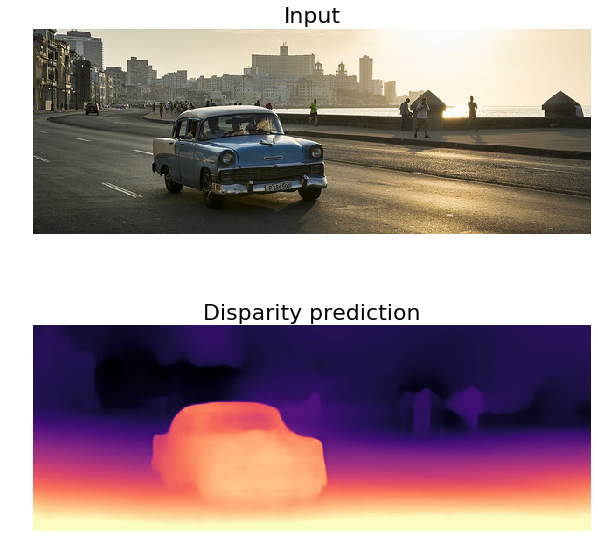

In [6]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');